In [57]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten,MaxPooling3D,AveragePooling3D, concatenate,Input

from math import e
from sklearn.model_selection import train_test_split
from keras.models import Model

In [2]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')
#plt.figure(figsize=[16,8])
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
y=fg.fogdata.sum(dim='stations').sel(time=slice('1980-1-1','2014-12-31'))
y=y/25.0
#y

In [4]:
# Input Data
t2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_t2m_daily_NovDecJan.nc')
d2mData = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_d2m_daily_NovDecJan.nc')
u10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_u10_daily_NovDecJan.nc')
v10Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_v10_daily_NovDecJan.nc')

In [5]:
rh = (e**((17.625*(d2mData.d2m.values-273.15))/(243.04+(d2mData.d2m.values-273.15)))/e**((17.625*(t2mData.t2m.values-273.15))/(243.04+(t2mData.t2m.values-273.15))))

rh_ds = xr.Dataset({'rh': (('time','latitude','longitude'), rh)}, coords={'time': t2mData.time,'latitude': t2mData.latitude,'longitude': t2mData.longitude})


In [6]:
t2m=t2mData.t2m.shift(time=1)
rh=rh_ds.rh.shift(time=1)
u10=u10Data.u10.shift(time=1)
v10=v10Data.v10.shift(time=1)

In [97]:
t2mTs=t2m[((t2m.time.dt.month>11) | (t2m.time.dt.month<2)) & (t2m.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
rhTs=rh[((rh.time.dt.month>11) | (rh.time.dt.month<2)) & (rh.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
u10Ts=u10[((u10.time.dt.month>11) | (u10.time.dt.month<2)) & (u10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))
v10Ts=u10[((v10.time.dt.month>11) | (v10.time.dt.month<2)) & (v10.time.dt.year<2020)].sel(time=slice('1980-1-1','2014-12-31'),latitude=slice(35,0),longitude=slice(50,100))

In [98]:
t2m_train, t2m_test, rh_train, rh_test,v10_train, v10_test,u10_train, u10_test,y_train,y_test = train_test_split( t2mTs, rhTs,v10Ts,u10Ts,y,test_size=0.20, random_state=0)

In [99]:
t2mtrain=t2m_train.values
t2mtrain=t2mtrain[:,:,:,None]
t2mtrain.shape
rhtrain=rh_train.values
rhtrain=rhtrain[:,:,:,None]
rhtrain.shape

u10train=u10_train.values
u10train=u10train[:,:,:,None]
u10train.shape

v10train=v10_train.values
v10train=v10train[:,:,:,None]
v10train.shape

(1736, 18, 26, 1)

In [100]:
ytrain=y_train.values
ytrain=ytrain[:,None]
ytrain.shape

(1736, 1)

In [101]:
t2mtest=t2m_test.values
t2mtest=t2mtest[:,:,:,None]
t2mtest.shape
rhtest=rh_test.values
rhtest=rhtest[:,:,:,None]
rhtest.shape
u10test=u10_test.values
u10test=u10test[:,:,:,None]
u10test.shape

v10test=v10_test.values
v10test=v10test[:,:,:,None]
v10test.shape

(434, 18, 26, 1)

In [116]:
X_test=np.array([rhtest,t2mtest,u10test,v10test])
X_test.shape

X_train=np.array([rhtrain,t2mtrain,u10train,v10train])
X_train.shape

(4, 1736, 18, 26, 1)

In [117]:
#nifti = np.random.randint(0,5,size=(508,512,513)) 
# set the last dim to 513 just to make stuff more clear
#nifti.shape
# (508, 512, 513)

X_train_reshape = np.einsum('lkija->klija',X_train)
X_train_reshape.shape

X_test_reshape = np.einsum('lkija->klija',X_test)
X_test_reshape.shape


(434, 4, 18, 26, 1)

In [118]:
ytest=y_test.values
ytest=ytest[:,None]
ytest.shape

(434, 1)

Epoch 1/10
55/55 [==============================] - 18s 323ms/step - loss: 102.8909 - val_loss: 0.1800
Epoch 2/10
55/55 [==============================] - 18s 321ms/step - loss: 0.1747 - val_loss: 0.1701
Epoch 3/10
55/55 [==============================] - 17s 313ms/step - loss: 0.1726 - val_loss: 0.1731
Epoch 4/10
55/55 [==============================] - 16s 295ms/step - loss: 0.1724 - val_loss: 0.1803
Epoch 5/10
55/55 [==============================] - 10s 184ms/step - loss: 0.1727 - val_loss: 0.1821
Epoch 6/10
55/55 [==============================] - 10s 186ms/step - loss: 0.1759 - val_loss: 0.1817
Epoch 7/10
55/55 [==============================] - 10s 187ms/step - loss: 0.1740 - val_loss: 0.1729
Epoch 8/10
55/55 [==============================] - 11s 200ms/step - loss: 0.1724 - val_loss: 0.1758
Epoch 9/10
55/55 [==============================] - 10s 189ms/step - loss: 0.1764 - val_loss: 0.1696
Epoch 10/10
55/55 [==============================] - 10s 186ms/step - loss: 0.1747 - val_

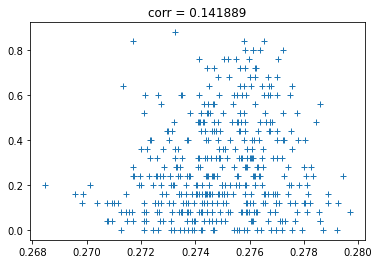

In [119]:
model = Sequential()

model.add(Conv3D(filters=32, kernel_size=5, activation='relu',padding='same', input_shape=(X_train_reshape.shape[1],X_train_reshape.shape[2],X_train_reshape.shape[3],1)))
#model.add(MaxPooling2D())

model.add(Conv3D(filters=64, kernel_size=3, activation='relu',padding='same'))
#model.add(MaxPooling2D())
model.add(Conv3D(filters=128, kernel_size=3, activation='relu'))
#model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
#model.add(Conv2D(filters=3, kernel_size=(1, 1), activation='relu'))
#model.add(AveragePooling2D())

model.add(Flatten())

#model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=1, activation = 'linear'))

model.compile(optimizer='adam', loss='mae')

history = model.fit(X_train_reshape, ytrain, validation_data=(X_test_reshape, ytest), epochs=10)
yy_test = model.predict(X_test_reshape)

test_corr = np.corrcoef(yy_test[:,0],y_test)[0,1]
plt.title('corr = %f'%test_corr)

plt.plot(yy_test,ytest,'+')